In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.models import resnet34
from torchvision.transforms import ToTensor
from transformers import DistilBertModel, DistilBertTokenizer
from torchvision import transforms
from PIL import Image


class ImageEncoder(nn.Module):
    def __init__(self, model_name):
        super(ImageEncoder, self).__init__()
        self.model = nn.Sequential(
            *list(models.resnet50(pretrained=True).children())[:-2]
        )

    def forward(self, image_batch):
        # Reshape the input to (batch_size, 3, 224, 224)
        image_batch = image_batch.view(-1, 3, 224, 224)
        # Encode the images using ResNet50
        image_features = self.model(image_batch)
        # Reshape to (batch_size, 2048, 49)
        image_features = image_features.view(image_features.size(0), 2048, -1)
        return image_features


class TextEncoder(nn.Module):
    def __init__(self, model_name, max_sequence_length):
        super(TextEncoder, self).__init__()
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.text_encoder = DistilBertModel.from_pretrained(model_name)
        self.max_sequence_length = max_sequence_length

    def forward(self, text_batch):
        # Tokenize and ensure the text has a fixed length of max_sequence_length
        text_encoded = self.tokenizer(
            text_batch,
            padding="max_length",
            truncation=True,
            max_length=self.max_sequence_length,
            return_tensors="pt",
        )
        text_encoded = text_encoded.to("cuda:0")
        # Encode the text using DistilBERT
        text_output = self.text_encoder(**text_encoded)

        # Extract embeddings for all tokens (last_hidden_state)
        text_embeddings = (
            text_output.last_hidden_state
        )  # This will have shape (batch_size, max_sequence_length, hidden_size)
        return text_embeddings


# Define the ProjectionHead class
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=512,  # Update the projection dimension
        dropout=0.1,
    ):
        super(ProjectionHead, self).__init__()  # Correct usage of super()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected  # skip connection
        x = self.layer_norm(x)  # Layer Normalization
        return x


# Cross-Attention module
class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttentionLayer, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.multihead_atten = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, image_features, text_features):
        key = text_features
        value = text_features
        query = image_features
        attn_output, attn_output_weights = self.multihead_atten(query, key, value)
        return attn_output, attn_output_weights


# cosine similarity
def cosine_similarity(avg_attn_out, avg_text_embed):
    dim = len(avg_attn_out)
    similarity_matrix = torch.zeros(dim, dim)
    for i in range(dim):
        for j in range(dim):
            similarity = F.cosine_similarity(avg_attn_out[i], avg_text_embed[j], dim=0)
            similarity_matrix[i, j] = similarity
    return similarity_matrix


# model
class DOGS(nn.Module):
    def __init__(
        self,
        max_sequence_length=50,
        embedding_dim=512,
    ):
        super(DOGS, self).__init__()
        self.image_encoder = ImageEncoder("resnet50")
        self.text_encoder = TextEncoder("distilbert-base-uncased", max_sequence_length)
        self.image_projection_head = ProjectionHead(2048)
        self.text_projection_head = ProjectionHead(768)
        self.cross_attention_layer = CrossAttentionLayer(embedding_dim, num_heads=4)

    def forward(self, image_batch, text_batch):
        # Encode images and texts
        image_features = self.image_encoder(image_batch)
        text_embeddings = self.text_encoder(text_batch)
        image_features = image_features.permute(0, 2, 1)
        # Project images and texts
        projected_images = self.image_projection_head(image_features)
        projected_texts = self.text_projection_head(text_embeddings)

        # Cross-attention
        attn_output, attn_output_weights = self.cross_attention_layer(
            projected_images.permute(1, 0, 2), projected_texts.permute(1, 0, 2)
        )
        attn_output = attn_output.permute(1, 0, 2)

        # Average pooling for image output
        avg_pool = nn.AdaptiveAvgPool1d(1)
        avg_attn_output = avg_pool(attn_output.permute(0, 2, 1))
        avg_attn_output = avg_attn_output.squeeze(dim=2)

        # CLS pooling for text output
        cls_embeddings = projected_texts[:, 0, :]

        # Compute the cosine similarity score
        score = cosine_similarity(avg_attn_output, cls_embeddings)
        return score, attn_output, text_embeddings, attn_output_weights, projected_images,projected_texts


# loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0, max_violation=False):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.max_violation = max_violation

    def forward(self, scores):
        diagonal = scores.diag()
        d1 = diagonal.expand_as(scores)
        d2 = diagonal.t().expand_as(scores)
        # compare every diagonal score to scores in its column # caption retrieval
        cost_s = (self.margin + scores - d1).clamp(min=0)
        # compare every diagonal score to scores in its row # image retrieval
        cost_im = (self.margin + scores - d2).clamp(min=0)

        return cost_s.sum() + cost_im.sum()



In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Check if GPU is available
if torch.cuda.is_available():
    # Create your model
    model = DOGS()
    # Move the model to the GPU
    model = model.to(
        "cuda:0"
    )  # You can also use model.to('cuda:0') for a specific GPU index

    for param in model.parameters():
        param.to("cuda:0")
    # Alternatively, you can use the .cuda() method
    # model = model.cuda()
else:
    model = DOGS()
    print("GPU is not available. Using CPU.")

# Count the learnable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total learnable parameters: {total_params}")

Using cuda device


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 80.6MB/s]


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Total learnable parameters: 92891712


In [ ]:
# Create an instance of the model
image_captioning_model = model
model_path = '/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/models (1)/model_epoch_10.pt'
image_captioning_model.load_state_dict(torch.load(model_path, map_location='cpu'))
image_captioning_model.eval()


DOGS(
  (image_encoder): ImageEncoder(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
    

In [ ]:
#Inference for batch of 4 image text pair
from transformers import BertTokenizer
t1 = "A man in a blue shirt is standing on a ladder cleaning a window."
t2 = "A trendy girl talking on her cellphone while gliding slowly down the street. "
t3 = "Five people are sitting in a circle with instruments."
t4 = "A man with a black shirt giving another man a tattoo."
statements = [t1,t2,t3,t4]

# Define image preprocessing transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

im1 = "/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/flickr30k_images/flickr30k_images/1000344755.jpg"
im2 = "/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/flickr30k_images/flickr30k_images/10010052.jpg"
im3 = "/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/flickr30k_images/flickr30k_images/1003420127.jpg"
im4 = "/content/drive/MyDrive/LINe-Out-of-Distribution-Detection-by-Leveraging-Important-Neurons/flickr30k_images/flickr30k_images/100577935.jpg"
image_paths = [im1, im2, im3, im4]
images = []
for image_path in image_paths:
    image = Image.open(image_path)
    image = image_transform(image)
    images.append(image)
# Stack the images into a single tensor
images = torch.stack(images)
images = images.to("cuda:0")
# Make predictions
with torch.no_grad():
    output = image_captioning_model(images, statements)
#print(output)

In [ ]:
output[0] #cross attention cosine similarity output

tensor([[-0.0051, -0.0051, -0.0051, -0.0051],
        [-0.0051, -0.0051, -0.0051, -0.0051],
        [-0.0051, -0.0051, -0.0051, -0.0051],
        [-0.0051, -0.0051, -0.0051, -0.0051]])

In [ ]:
output[4].shape#projected image features

torch.Size([4, 49, 512])

In [ ]:
output[5].shape#projected text features

torch.Size([4, 50, 512])

In [ ]:
output[3].shape#attention output weights

torch.Size([4, 49, 50])

In [ ]:
attn_mapping = output[3]

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def plot_attention_maps( attention_map):
    fig = plt.figure(figsize=(15, 10))
    len_result = 50
    titles = []
    for i in range(len_result):
        map = attention_map[i]
        grid_size = max(int(np.ceil(len_result / 5)), 5)
        ax = fig.add_subplot(5, grid_size, i + 1)
        ax.imshow(map, cmap='gray', alpha=0.6)
    plt.tight_layout()


In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
tokenized_statements = [
    tokenizer.encode(
        statement,
        add_special_tokens=True,
        padding="max_length",
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )
    for statement in statements
]
tokenized_statements = [tokenized_statement.to("cuda:0") for tokenized_statement in tokenized_statements]
tokenized_statements = torch.stack(tokenized_statements)
reshaped_tokenized_statements = tokenized_statements.squeeze(1)
print(tokenized_statements.shape)

torch.Size([4, 1, 50])


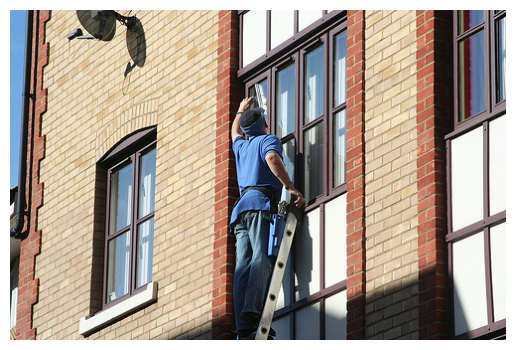

A man in a blue shirt is standing on a ladder cleaning a window.


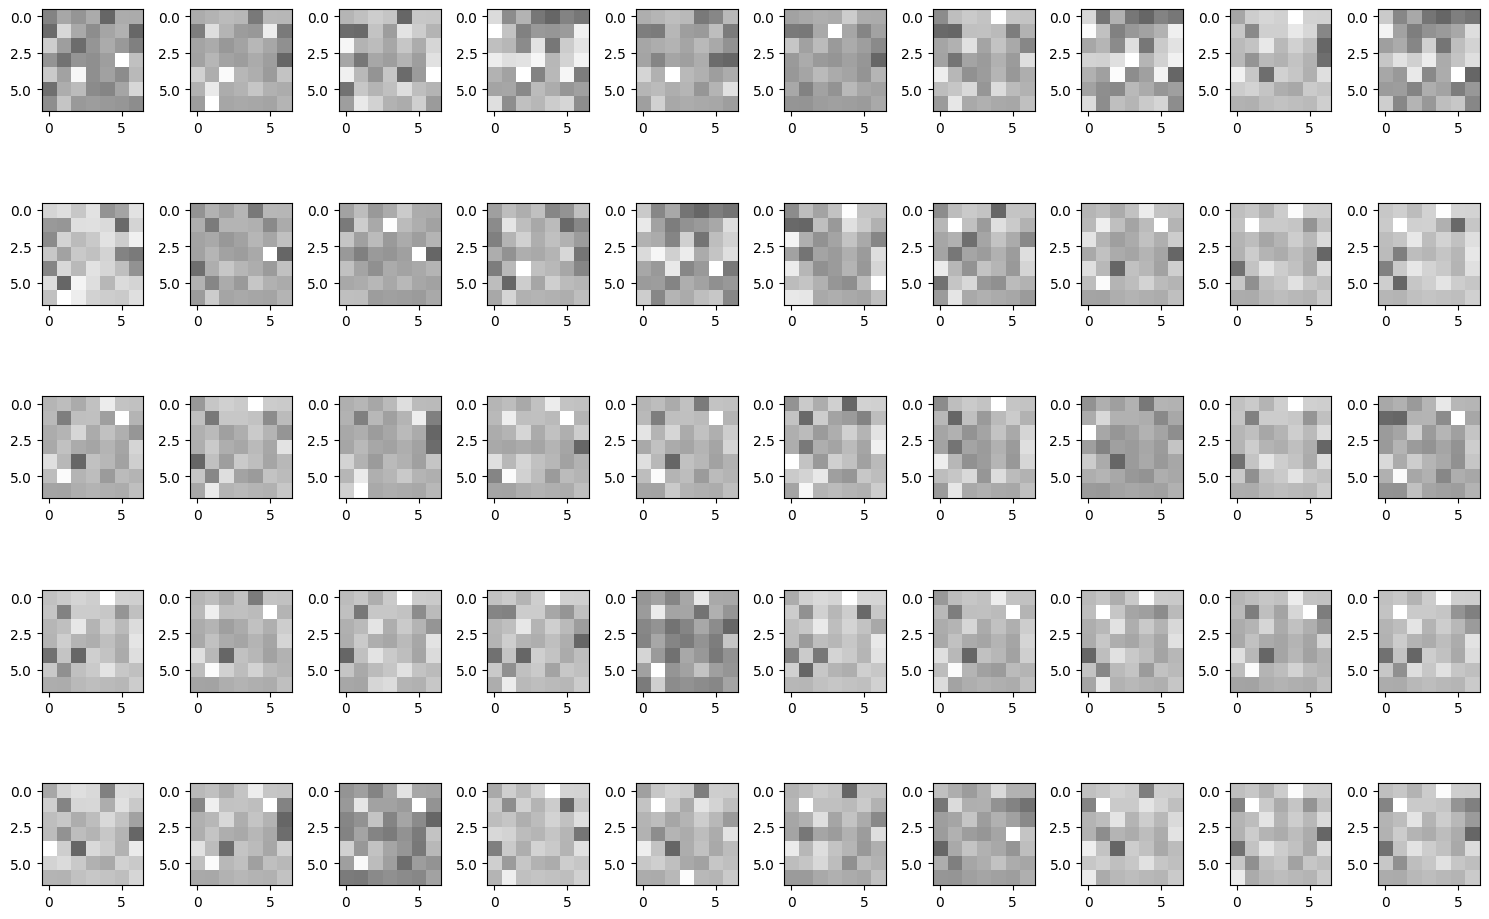

In [ ]:
image = Image.open(im1)
plt.imshow(image)
plt.axis('off')
plt.show()
print(statements[0])
#print(tokenized_statements[0])
attn_sc = attn_mapping[0].cpu()
attn_maps = attn_sc.permute(1,0)
attn_maps = attn_maps.view(50, 7, 7)
plot_attention_maps(attn_maps)
plt.show()

In [ ]:
model_name = "distilbert-base-uncased"
max_sequence_length = 50
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
text_encoder = DistilBertModel.from_pretrained(model_name)
# Tokenize and ensure the text has a fixed length of max_sequence_length
text_encoded = tokenizer(
            statements,
            padding="max_length",
            truncation=True,
            max_length=max_sequence_length,
            return_tensors="pt",
        )

# Encode the text using DistilBERT
text_output = text_encoder(**text_encoded)# input (4,50) with padding 0's to the distilbert text encoder, outputs
# Extract embeddings for all tokens (last_hidden_state)
text_embeddings = (text_output.last_hidden_state )  # This will have shape (batch_size, max_sequence_length, hidden_size)
print("text embedding shape :", text_embeddings.shape)

text embedding shape : torch.Size([4, 50, 768])


In [ ]:
print(text_encoded)

{'input_ids': tensor([[  101,  1037,  2158,  1999,  1037,  2630,  3797,  2003,  3061,  2006,
          1037, 10535,  9344,  1037,  3332,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1037,  9874,  2100,  2611,  3331,  2006,  2014,  3526,  9864,
          2096, 20292,  3254,  2091,  1996,  2395,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  2274,  2111,  2024,  3564,  1999,  1037,  4418,  2007,  5693,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,

In [ ]:
import torch

# Assuming you have the 'c' tensor defined somewhere
# For example, let's create a dummy tensor for illustration purposes
c = torch.randn(4, 4, device='cuda:0')

# Given diagonal tensor
diagonal = torch.tensor([9459774., 9548210., 9245730., 9372464.], device='cuda:0')

# Create d1 by expanding diagonal to the shape of c
d1 = diagonal.expand_as(c)

# Create d2 by transposing diagonal and then expanding it to the shape of c
d2 = diagonal.t().expand_as(c)

# Print the results
print("d1:")
print(d1)

print("\nd2:")
print(d2)


d1:
tensor([[9459774., 9548210., 9245730., 9372464.],
        [9459774., 9548210., 9245730., 9372464.],
        [9459774., 9548210., 9245730., 9372464.],
        [9459774., 9548210., 9245730., 9372464.]], device='cuda:0')

d2:
tensor([[9459774., 9548210., 9245730., 9372464.],
        [9459774., 9548210., 9245730., 9372464.],
        [9459774., 9548210., 9245730., 9372464.],
        [9459774., 9548210., 9245730., 9372464.]], device='cuda:0')


In [ ]:
import torch

# Assuming you have the 'c' tensor defined somewhere
# For example, let's create a dummy tensor for illustration purposes
c = torch.randn(4, 4, device='cuda:0')

# Given diagonal tensor
diagonal = torch.tensor([9459774., 9548210., 9245730., 9372464.], device='cuda:0')

# Create dl matrix with diagonal elements as columns
dl = torch.diag(diagonal).t()

# Create d2 matrix with diagonal elements as rows
d2 = torch.diag(diagonal).clone()

# Print the results
print("dl:")
print(dl)

print("\nd2:")
print(d2)


dl:
tensor([[9459774.,       0.,       0.,       0.],
        [      0., 9548210.,       0.,       0.],
        [      0.,       0., 9245730.,       0.],
        [      0.,       0.,       0., 9372464.]], device='cuda:0')

d2:
tensor([[9459774.,       0.,       0.,       0.],
        [      0., 9548210.,       0.,       0.],
        [      0.,       0., 9245730.,       0.],
        [      0.,       0.,       0., 9372464.]], device='cuda:0')
